**Naive Bayes with GloVe embedding**

The notebook is equivalent for both GloVe embedding files tested. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sn
import pickle

%matplotlib inline

#Import module to split the datasets
from sklearn.model_selection import train_test_split
# Import modules to evaluate the metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc

In [3]:
train = pd.read_csv('/content/drive/MyDrive/Thesis/Data/Filled Datasets/Second dataset (Kaggle)/Preprocessed/combined_train_val.csv',header=0)
test = pd.read_csv('/content/drive/MyDrive/Thesis/Data/Filled Datasets/Second dataset (Kaggle)/Preprocessed/Constraint_Test_fullprep_with_labels.csv')
print(train.head(n=3))
print(test.head(n=3))

                                               tweet  label
0  cdc currently reports deaths general discrepan...      0
1  states reported deaths small rise last tuesday...      0
2  politically correct woman almost uses pandemic...      1
   id                                              tweet  label
0   1  daily update published states reported k tests...      0
1   2                                 alfalfa cure covid      1
2   3      president trump asked would catch coronavirus      1


In [4]:
y_train = train["label"]
X_train = train["tweet"]
y_test = test["label"]
X_test = test["tweet"]

In [26]:
glove_filename='/content/drive/MyDrive/Thesis/Data/Embedding files/glove.twitter.27B.100d.txt'

In [27]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
word2vec_output_file = glove_filename+'.word2vec'
model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [28]:
class Word2VecVectorizer:
  def __init__(self, model):
    print("Loading in word vectors...")
    self.word_vectors = model
    print("Finished loading in word vectors")

  def fit(self, data):
    pass

  def transform(self, data):
    # determine the dimensionality of vectors
    v = self.word_vectors.get_vector('king')
    self.D = v.shape[0]

    X = np.zeros((len(data), self.D))
    n = 0
    emptycount = 0
    for sentence in data:
      tokens = sentence.split()
      vecs = []
      m = 0
      for word in tokens:
        try:
          # throws KeyError if word not found
          vec = self.word_vectors.get_vector(word)
          vecs.append(vec)
          m += 1
        except KeyError:
          pass
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = vecs.mean(axis=0)
      else:
        emptycount += 1
      n += 1
    print("Numer of samples with no words found: %s / %s" % (emptycount, len(data)))
    return X


  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)

In [29]:
# Set a word vectorizer
vectorizer = Word2VecVectorizer(model)
# Get the sentence embeddings for the train dataset
Xtrain = vectorizer.fit_transform(X_train)
Ytrain = y_train
# Get the sentence embeddings for the test dataset
Xtest = vectorizer.transform(X_test)
Ytest = y_test

Loading in word vectors...
Finished loading in word vectors
Numer of samples with no words found: 1 / 8558
Numer of samples with no words found: 0 / 2139


In [30]:
print(Xtrain.shape,Xtest.shape)
#dimensions indeed 100! 

(8558, 100) (2139, 100)


oversampling 

In [31]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
Xtrain, Ytrain = smote.fit_resample(Xtrain,Ytrain)

In [32]:
print(Xtrain.shape,Xtest.shape)
#dimensions should be (x,100) 

(8960, 100) (2139, 100)


In [14]:
# Create the confussion matrix
def plot_confussion_matrix(y_test, y_pred):
    ''' Plot the confussion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confussion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))
    #plt.figure(figsize = (10,7))
    # Plot the confussion matrix
    sn.set(font_scale=1.4) #for label size
    sn.heatmap(df_cm, annot=True,fmt='.0f',annot_kws={"size": 10})# font size
    plt.show()
    
# ROC Curve
# plot no skill
# Calculate the points in the ROC curve
def plot_roc_curve(y_test, y_pred):
    ''' Plot the ROC curve for the target labels and predictions'''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc= auc(fpr,tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

**THE NB MODEL:**



In [33]:
import numpy as np, pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import CountVectorizer

Regular GaussianNB()

In [34]:
NB = GaussianNB() #interesting: MultinomailNB doesn't work as Xtrain has negative values and MultinomialNB can't handle this
NB.fit(Xtrain,Ytrain)
print("train score:", NB.score(Xtrain, Ytrain))
print("test score:", NB.score(Xtest, Ytest))

train score: 0.7760044642857142
test score: 0.7858812529219261


              precision    recall  f1-score   support

           0    0.78764   0.80876   0.79806      1119
           1    0.78384   0.76078   0.77214      1020

    accuracy                        0.78588      2139
   macro avg    0.78574   0.78477   0.78510      2139
weighted avg    0.78583   0.78588   0.78570      2139



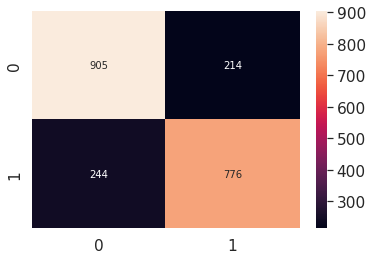

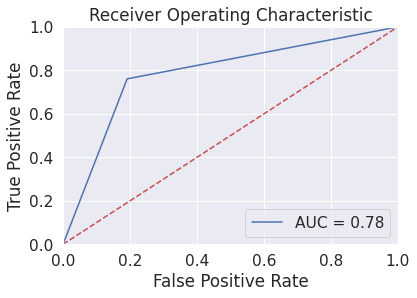

In [35]:
y_pred = NB.predict(Xtest)

print(metrics.classification_report(Ytest, y_pred,  digits=5))
plot_confussion_matrix(Ytest, y_pred)
plot_roc_curve(Ytest, y_pred)

GaussianNB() with grid search

In [36]:
from sklearn.model_selection import GridSearchCV
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
nbModel_grid.fit(Xtrain, Ytrain)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


GridSearchCV(cv=10, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.848035...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             verbose=1)

In [37]:
nbModel_grid.best_params_

{'var_smoothing': 0.0012328467394420659}

In [38]:
NB_grid = GaussianNB(var_smoothing = 0.0006579332246575676) 
NB_grid.fit(Xtrain,Ytrain)
print("train score:", NB_grid.score(Xtrain, Ytrain))
print("test score:", NB_grid.score(Xtest, Ytest))

train score: 0.7756696428571429
test score: 0.7858812529219261


In [39]:
y_pred = NB_grid.predict(Xtest)

print(metrics.classification_report(Ytest, y_pred,  digits=5))
print(confusion_matrix(Ytest,y_pred))

              precision    recall  f1-score   support

           0    0.78418   0.81501   0.79930      1119
           1    0.78791   0.75392   0.77054      1020

    accuracy                        0.78588      2139
   macro avg    0.78604   0.78447   0.78492      2139
weighted avg    0.78596   0.78588   0.78559      2139

[[912 207]
 [251 769]]
